In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_csv('text.csv')

df.head()

,id,training_id,device_id,movement_id,repetition,timestamp,raw
0,1,1,1,1,1,2025-12-08T23:05:04.142018Z,"3248,3233,3233,2208,16,0,1345,2289,3121,3217,3..."
1,2,1,1,1,1,2025-12-08T23:05:04.245016Z,"3232,3232,65,1,929,2048,3008,3217,3233,3232,11..."
2,3,1,1,1,1,2025-12-08T23:05:04.348016Z,"2336,17,0,1569,2657,3217,3216,3217,3233,48,1,1..."
3,4,1,1,1,1,2025-12-08T23:05:04.451018Z,"0,784,2096,3104,3232,3249,3233,1136,32,512,179..."
4,5,1,1,1,1,2025-12-08T23:05:04.555016Z,"1697,2641,3217,3232,3233,3264,49,33,1233,2256,..."


In [ ]:
df['movement_id'].unique

<bound method Series.unique of 0      1
1      1
2      1
3      1
4      1
      ..
730    3
731    3
732    3
733    3
734    3
Name: movement_id, Length: 735, dtype: int64>

In [ ]:
df["raw_array"] = df["raw"].apply(lambda x: np.array(list(map(int, x.split(",")))))

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

movements = df["movement_id"].unique()
print("Movements:", movements)

m1, m2 = movements[0], movements[1]
print(f"Comparing movement {m1} vs {m2}")

df1 = df[df["movement_id"] == m1]
df2 = df[df["movement_id"] == m2]

A = np.vstack(df1["raw_array"].values)
B = np.vstack(df2["raw_array"].values)

meanA = A.mean(axis=0)
meanB = B.mean(axis=0)

meanA_norm = (meanA - meanA.mean()) / meanA.std()
meanB_norm = (meanB - meanB.mean()) / meanB.std()

cosine = cosine_similarity([meanA_norm], [meanB_norm])[0][0]
mse = np.mean((meanA_norm - meanB_norm)**2)
corr = np.corrcoef(meanA_norm, meanB_norm)[0, 1]

print("Cosine similarity:", cosine)
print("MSE:", mse)
print("Correlation:", corr)


Movements: [1 2 3]
Comparing movement 1 vs 2
Cosine similarity: 0.6242203940814172
MSE: 0.7515592118371657
Correlation: 0.6242203940814168


Movements: [1 2 3]


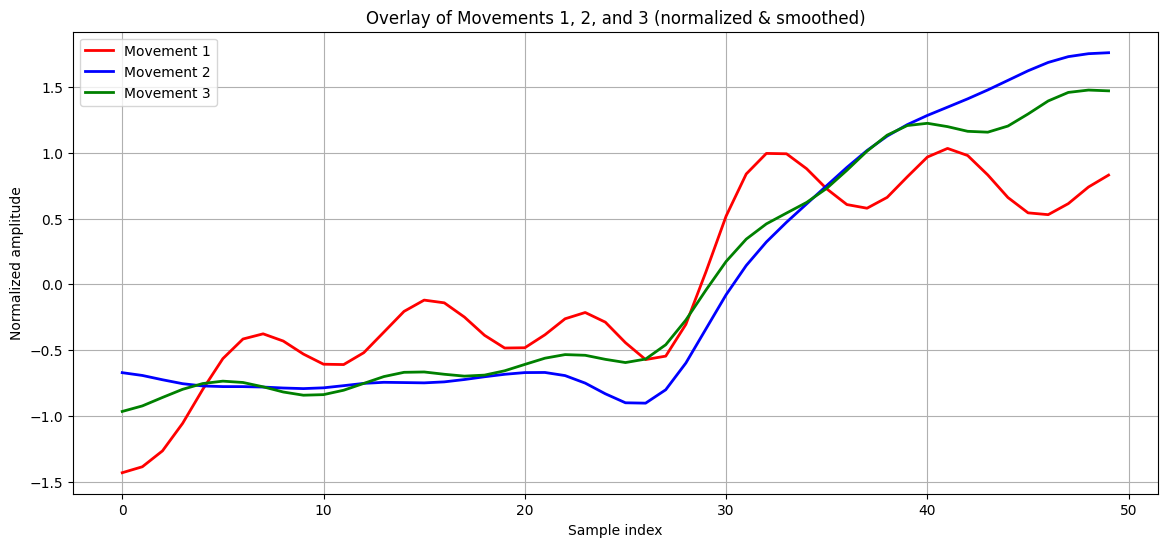

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

movements = df["movement_id"].unique()
print("Movements:", movements)

colors = ["red", "blue", "green"]
plt.figure(figsize=(14, 6))

for idx, m in enumerate(movements):
    df_m = df[df["movement_id"] == m]

    M = np.vstack(df_m["raw_array"].values)

    meanM = M.mean(axis=0)

    meanM_norm = (meanM - meanM.mean()) / meanM.std()

    meanM_smooth = gaussian_filter1d(meanM_norm, sigma=2)

    plt.plot(
        meanM_smooth,
        label=f"Movement {m}",
        color=colors[idx % len(colors)],
        linewidth=2
    )

plt.title("Overlay of Movements 1, 2, and 3 (normalized & smoothed)")
plt.xlabel("Sample index")
plt.ylabel("Normalized amplitude")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
df = pd.read_csv('text.csv')

In [ ]:
df["raw_vec"] = df["raw"].apply(lambda s: np.array(list(map(int, s.split(",")))))

In [ ]:
def mav(x): return np.mean(np.abs(x))
def rms(x): return np.sqrt(np.mean(x**2))
def wl(x): return np.sum(np.abs(np.diff(x)))
def var(x): return np.var(x)
def zero_cross(x): return np.sum((x[:-1] * x[1:]) < 0)
def ssc(x): return np.sum(np.diff(np.sign(np.diff(x))) != 0)

In [ ]:
def extract_features(x):
    return np.array([
        mav(x),
        rms(x),
        wl(x),
        var(x),
        zero_cross(x),
        ssc(x),
        np.max(x),
        np.min(x)
    ])

In [ ]:
X = np.array([extract_features(v) for v in df["raw_vec"]])
y = to_categorical(df["movement_id"].values - 1, 3)

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
X.shape[1]

8

In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

/Users/diyar/learn/final/emg_esp32_classifier_ml/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7574 - loss: 0.4230 - val_accuracy: 0.7458 - val_loss: 0.4877
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7404 - loss: 0.4780 - val_accuracy: 0.7203 - val_loss: 0.4741
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7255 - loss: 0.5015 - val_accuracy: 0.2966 - val_loss: 1.4494
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319 - loss: 0.4723 - val_accuracy: 0.7373 - val_loss: 0.6348
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7362 - loss: 0.4544 - val_accuracy: 0.7288 - val_loss: 0.4845
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7319 - loss: 0.4629 - val_accuracy: 0.6864 - val_loss: 0.6281
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7149 - loss: 0.4694 - val_accuracy: 0.6949 - val_loss: 0.5445
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7745 - loss: 0.4554 - val_accuracy: 0.7203 - val_loss:

In [ ]:
loss, acc = model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8095 - loss: 0.3451


In [ ]:
model.save("emg_ann.keras")

In [ ]:
import joblib

joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [ ]:
print(acc)

0.8095238208770752


# CNN

In [ ]:
X = np.array(df["raw_vec"].tolist())
y = df["movement_id"].values - 1   # 0,1,2

num_classes = len(np.unique(y))
y_cat = to_categorical(y, num_classes)

In [ ]:
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
model = Sequential([

    Conv1D(32, kernel_size=7, activation='relu', input_shape=(X.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


# -------------------------------------------------------
# EVALUATE
# -------------------------------------------------------
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)